# LowCarb thorax disease classification in Flower

## Check GPU availability

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 20 17:06:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    55W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create dirs, get data 

In [2]:
# !mkdir NIH
# !mkdir /root/.kaggle/

### Copy Kaggle API-key to created directory at '/root/.kaggle'

In [3]:
# !cp '/content/drive/MyDrive/professional/Research_Jobs/UMI/projects/APIs/kaggle.json' '/root/.kaggle'

In [4]:
# !kaggle datasets download -d nih-chest-xrays/data

100% 42.0G/42.0G [02:56<00:00, 350MB/s]
100% 42.0G/42.0G [02:56<00:00, 255MB/s]


In [5]:
# !unzip -q '/content/data.zip' -d '/content/NIH/'

## Install packages

In [6]:
!pip install flwr[simulation]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 3.8 MB/s 
     |████████████████████████████████| 1.0 MB 28.6 MB/s 
     |████████████████████████████████| 54.5 MB 244 kB/s 
     |████████████████████████████████| 8.8 MB 38.1 MB/s 
     |████████████████████████████████| 4.1 MB 67.7 MB/s 
     |████████████████████████████████| 57 kB 6.1 MB/s 
     |████████████████████████████████| 90 kB 12.5 MB/s 
     |████████████████████████████████| 128 kB 76.3 MB/s 
     |████████████████████████████████| 3.0 MB 63.1 MB/s 
     |████████████████████████████████| 201 kB 86.4 MB/s 
     |████████████████████████████████| 291 kB 84.4 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
     |████████████████████████████████| 468 kB 68.5 MB/s 
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19889 sha256=87030987d7ebb6c5d0d7a76e0fc6f0c338a0d998d447ff413724212090b7201a
  

## Imports

In [2]:
import os
import sys
import math
from glob import glob
from PIL import Image
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nnqunt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms as T, models

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print(f"Training on {DEVICE}")

Training on cuda:0


## Data

### Preprocess

In [3]:
root_img_dir = '/content/NIH/'

In [4]:
all_xray_df = pd.read_csv(
    os.path.join(
        root_img_dir,
        'Data_Entry_2017.csv'
        )
    )

all_image_paths = {
    os.path.basename(x): x for x in 
    glob(os.path.join(root_img_dir, 'images*', '*', '*.png'))
    }

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))

all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
2872,00000765_004.png,No Finding,4,765,38,M,PA,2992,2991,0.143,0.143,NaN,/content/NIH/images_001/images/00000765_004.png
103443,00027600_000.png,Infiltration,0,27600,26,F,PA,2992,2991,0.143,0.143,NaN,/content/NIH/images_011/images/00027600_000.png
86474,00021321_001.png,Pneumothorax,1,21321,48,F,PA,3056,2544,0.139,0.139,NaN,/content/NIH/images_010/images/00021321_001.png


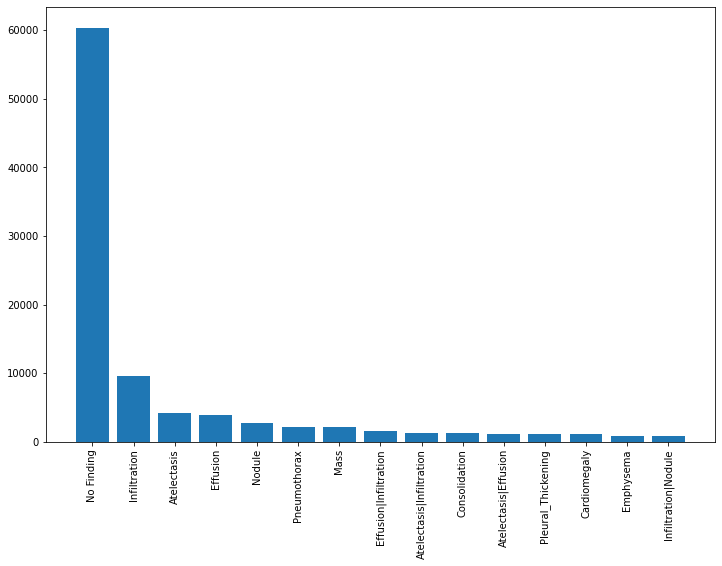

In [5]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [6]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
76802,00018865_022.png,Emphysema,22,18865,70,F,PA,2594,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106202,00028591_006.png,,6,28591,58,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75949,00018626_015.png,Consolidation,15,18626,28,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [
    c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES
    ]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


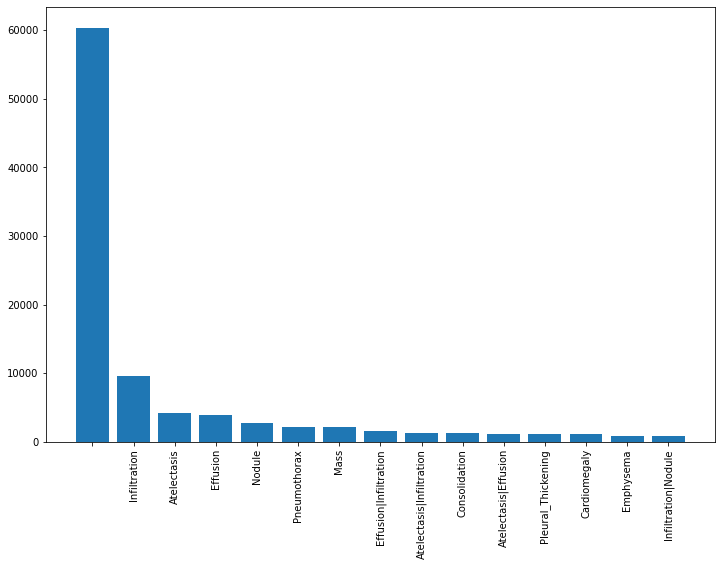

In [8]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()

all_xray_df = all_xray_df.sample(112120, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

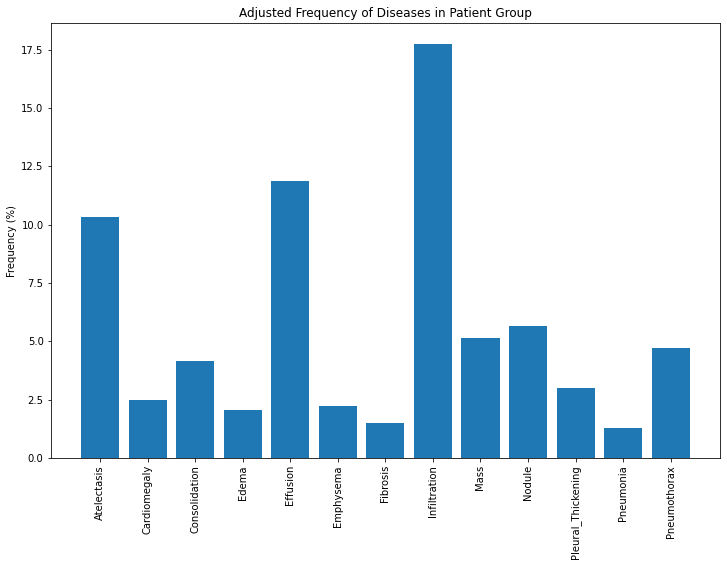

In [9]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [10]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [11]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
26201,00006875_020.png,Consolidation|Effusion|Infiltration,20,6875,55,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
39347,00010312_002.png,,2,10312,69,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22526,00005969_001.png,Mass,1,5969,46,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [12]:
len(all_xray_df)

112120

In [14]:
num_clients = 100

trainloaders, valloaders, testloader = get_data_loaders(
    all_xray_df,
    global_train_frac = 0.95,
    local_train_frac = 0.9,
    num_clients = num_clients,
    batch_size = 25
)

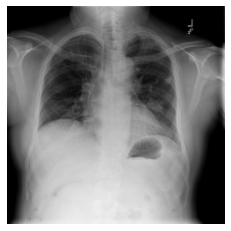

In [15]:
plt.imshow(
    inv_data_transform(
        testloader.dataset[0][0]
    )
)
plt.axis('off');

In [16]:
len(trainloaders[0].dataset), len(valloaders[0].dataset) ,len(testloader.dataset)

(959, 106, 5607)

In [17]:
len(all_labels)

13

## Training

### Util function

In [ ]:
def client_fn(cid) -> FlowerClient:
    net = init_net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    print(f'Created client: {cid}')
    return FlowerClient(cid, net, trainloader, valloader)

### 35 local epochs result in approx. 15min. local training time

In [ ]:
num_rounds = 100
local_epochs = 35
fraction_fit = 0.1
fraction_evaluate = 0.1
min_fit_clients = 10
min_evaluate_clients = 10

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

def fit_config(server_round: int):    
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
)

INFO flower 2022-10-20 17:07:59,754 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO flower 2022-10-20 17:08:02,631 | app.py:179 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.2': 1.0, 'CPU': 12.0, 'object_store_memory': 26770797772.0, 'memory': 53541595547.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.2': 1.0, 'CPU': 12.0, 'object_store_memory': 26770797772.0, 'memory': 53541595547.0}
INFO flower 2022-10-20 17:08:02,635 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-20 17:08:02,638 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-20 17:08:02,640 | server.py:88 | Evaluating initial parameters
INFO:flower:Evaluating


Server eval
                Labels  Class Acc.
0          Atelectasis   82.307829
1         Cardiomegaly   96.736223
2        Consolidation   73.693597
3                Edema   97.627965
4             Effusion   71.339397
5            Emphysema   94.738719
6             Fibrosis   96.914571
7         Infiltration   81.701445
8                 Mass   94.132335
9               Nodule   84.519351
10  Pleural_Thickening   96.326021
11           Pneumonia   98.698056
12        Pneumothorax   94.025325


(launch_and_fit pid=4613) Created client: 6
(launch_and_fit pid=4613) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 35}
(launch_and_fit pid=4613) Entered train function, total num. of epochs: 35
(launch_and_fit pid=4613) Iteration 0, loss: 0.7854915060113733
(launch_and_fit pid=4613) Epoch : 1 Train Loss : 0.913871 
(launch_and_fit pid=4613) Iteration 0, loss: 0.7870507666847981
(launch_and_fit pid=4613) Epoch : 2 Train Loss : 0.905857 
(launch_and_fit pid=4613) Itera